# Shoe Sandal Boot Classification

## Reference
- [Dataset Link](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images)

## Outline
- Prepare Notebook
- Explore Dataset
- Load and Preprocess Dataset
- Config GPU
- CNN
    - Define Model
    - Model Training
    - Evaluation
    - Testing

## Motive
- To compare CNN and RESNET
- Get to know lifecyle of Deep Learning
- Get to know Neural Network architecture

### Prepare Notebook

First Let's import packages, we are going to use.

In [42]:
# Importing Necessary Packages
import os
import random
from PIL import Image

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

import warnings
warnings.filterwarnings('ignore')

### Explore Dataset

Before loading our dataset, Let's explore it, Because we get to know some information about the Images.

In [2]:
# First Exploring Parent Directory

PARENT_DIR = '/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/'

print(f"Parent Directory Contains: {os.listdir(PARENT_DIR)}")

Parent Directory Contains: ['Shoe', 'Sandal', 'Boot']


In [3]:
# Second Exploring Sub-Folder's Lenght

for i in os.listdir(PARENT_DIR):
    print(f"{i} Folder's Length {len(os.listdir(PARENT_DIR + i))}")

Shoe Folder's Length 5000
Sandal Folder's Length 5000
Boot Folder's Length 5000


In [4]:
def plotRandomImage(subFolder):
    """Function Plot Random Image from give sub-folder"""
    path = PARENT_DIR + subFolder
    randInt = random.randrange(0, len(path))
    data = os.listdir(path)
    img = Image.open(path + '/' + data[randInt])
    print(f'Image Size: {img.size}')
    return img

Image Size: (136, 102)


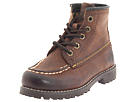

In [5]:
# Plotting Image from Boot

plotRandomImage('Boot')

Image Size: (136, 102)


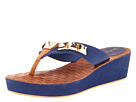

In [6]:
# Plotting Image from Sandal

plotRandomImage('Sandal')

Image Size: (136, 102)


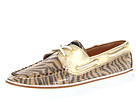

In [7]:
# Plotting Image from Shoe

plotRandomImage('Shoe')

*Key Insight*
- On Exploring
    - We get to know that parent directory contains three sub-folders ( Show, Sandal, Boots).
    - Each Sub Folder contains equal amount of images i.e 5000.
    - Every image is at same size i.e (136, 102).

- Methods
    - Resize every images to (100, 100).
    - Use Regularization Methods.
    - Convert to Tensor.

### Load and Preprocess Dataset

Now that we got some information about the dataset, let's apply some transformation and convert it to tensor

In [8]:
# Applying Regularization to Images

dataTransform = tt.Compose([
    tt.Resize(100),
    tt.RandomCrop(80),
    tt.RandomHorizontalFlip(),
    tt.ToTensor()
])

In [9]:
# Converting ImageFolder to Dataset

dataset = ImageFolder(PARENT_DIR, transform = dataTransform)
classes = dataset.classes

print(f"Classes of Dataset: {classes}")
print(f"Length of Dataset: {len(dataset)}")

Classes of Dataset: ['Boot', 'Sandal', 'Shoe']
Length of Dataset: 15000


Now that we applied some changes and it's converted from `PIL Image` to `Tensors`, Let's check the shape of the Image and Plot those images

In [10]:
# Checking Shape of Tensors

for i in [3, 33, 333, 3333]:
    img, label = dataset[i]
    print(f"Image Shape of {label}: {img.size()}")

Image Shape of 0: torch.Size([3, 80, 80])
Image Shape of 0: torch.Size([3, 80, 80])
Image Shape of 0: torch.Size([3, 80, 80])
Image Shape of 0: torch.Size([3, 80, 80])


In [11]:
def plotTensor(num):
    """Function to Plot Tensors"""
    img, label = dataset[num]
    print(f'Label is {classes[label]}')
    plt.imshow(img.permute((1, 2, 0)))
    plt.show()

Label is Boot


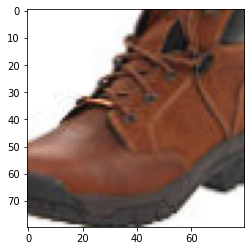

In [12]:
plotTensor(44)

Label is Shoe


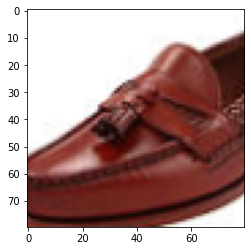

In [13]:
plotTensor(12000)

Label is Sandal


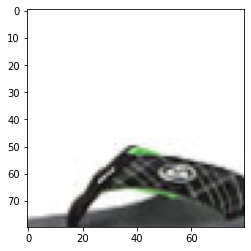

In [14]:
plotTensor(5555)

So now we load Images and Plotted our transformation. Now let's split into `Training` and `Validation` dataset. We just going to use **2%** of the Original Dataset. For testing we take images from the *internet*.

In [15]:
# Splitting original dataset 80% for training and 20% for validation

valSize = int(len(dataset) * 0.2)
trainSize = int(len(dataset) - valSize)

trainDs, valDs = random_split(dataset, [trainSize, valSize])
len(trainDs), len(valDs)

(12000, 3000)

Now let's create DataLoader with our Datasets

In [16]:
# Creating DataLoader with batch size as 128

batchSize = 128

trainLoader = DataLoader(
    trainDs,
    batch_size = batchSize,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

valLoader = DataLoader(
    valDs,
    batch_size = batchSize,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

Let's plot a batch from each dataloader

In [17]:
def plotBatch(dataLoader):
    """Function to plot One Batch from Dataloader"""
    for images, labels in dataLoader:
        fig, ax = plt.subplots(figsize = (16, 10))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute((1, 2, 0)))
        break

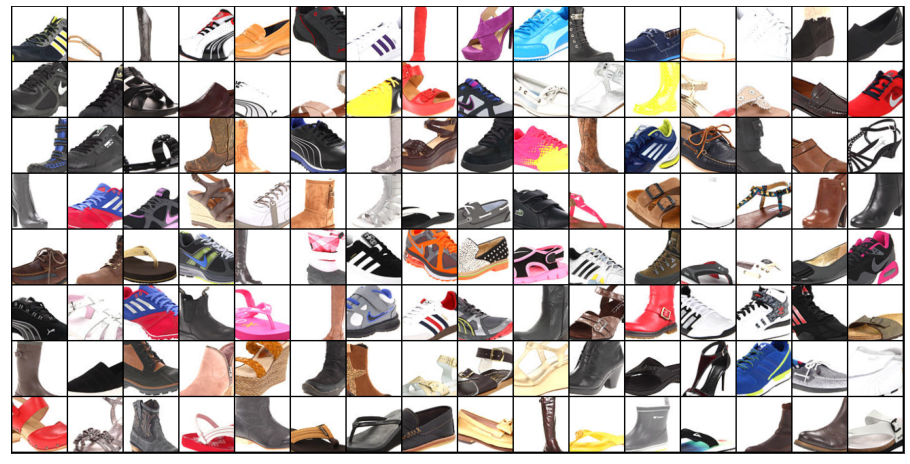

In [18]:
plotBatch(trainLoader)

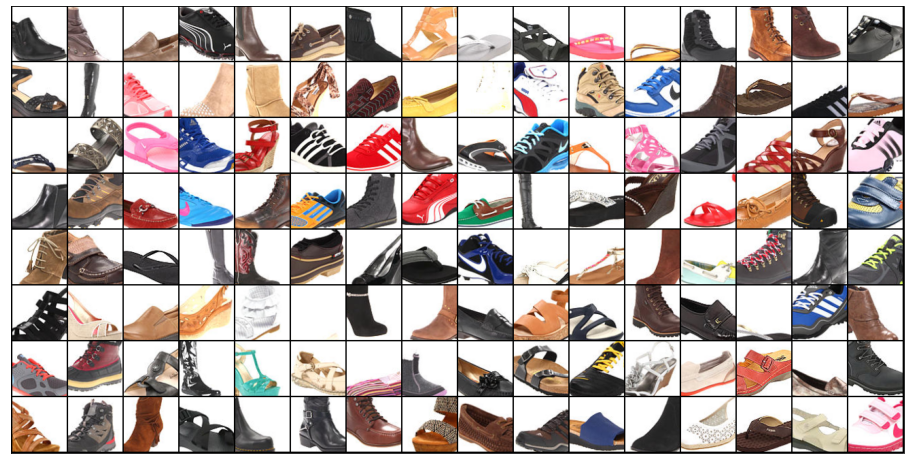

In [19]:
plotBatch(valLoader)

### Config GPU

Let's make our code work on both `CPU` and `GPU`

In [20]:
def getDevice():
    """Function to Get available device"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def toDevice(data, device):
    """Function to convert data to given device"""
    if isinstance(data, (list, tuple)):
        return [toDevice(x, device) for x in data]
    return data.to(device, non_blocking = True)

# Class for Converting DataLoader to Given device

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yielding Batch of Images"""
        for batch in self.dl:
            yield toDevice(batch, self.device)
    
    def __len__(self):
        """Function to return the length of DataLoader"""
        return len(self.dl)

Let's check for conversion and availability by a sample dataset

In [21]:
for images, _ in trainLoader:
    print(f"Before Conversion: {images.device}")
    images = toDevice(images, getDevice())
    print(f"After Convertion: {images.device}")
    break

Before Conversion: cpu
After Convertion: cuda:0


Conversion Successuful. let's change the whole dataloader

In [22]:
device = getDevice()

trainLoader = DeviceDataLoader(trainLoader, device)
valLoader = DeviceDataLoader(valLoader, device)

### CNN - Define Model

We configured GPU to our code, create Dataloader, Splitted Dataset, visualized Single image as well as One batch. Now let's Create our Model for training.

In [23]:
# Model Class

class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(128 * 20 * 20, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
    
    def forward(self, xb):
        return self.network(xb)

We defined our Model. Now it's time to train our model with dataset. First with `training_step` next with `validation_step` and then we store the results for plotting

In [24]:
# Storage for our results

results = {
    'trainLoss' : [],
    'trainAcc' : [],
    'valLoss': [],
    'valAcc': []
}

In [25]:
def trainStep(model, dataLoader, lossFu, optimizer):
    """Function to Train the Model"""
    model.train()
    trainLoss, trainAcc = 0, 0
    for batch, (X, y) in enumerate(dataLoader):
        yPred = model(X)
        loss = lossFu(yPred, y)
        trainLoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        yPredClass = torch.argmax(torch.softmax(yPred, dim = 1), dim = 1)
        trainAcc += (yPredClass == y).sum().item() / len(yPred)
        trainLoss = trainLoss / len(dataLoader)
        trainAcc = trainAcc / len(dataLoader)
        return trainLoss, trainAcc

In [26]:
def valStep(model, dataLoader, lossFu):
    """Function for Validating model"""
    model.eval() 
    valLoss, valAcc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataLoader):
            testPredLogits = model(X)
            loss = lossFu(testPredLogits, y)
            valLoss += loss.item()
            testPredLabels = testPredLogits.argmax(dim=1)
            valAcc += ((testPredLabels == y).sum().item()/len(testPredLabels))
    valLoss = valLoss / len(dataLoader)
    valAcc = valAcc / len(dataLoader)
    return valLoss, valAcc

In [27]:
cnnModel = CNN_Model().to(device)
epochs = 5
lossFu = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = cnnModel.parameters(), lr = 0.001)

In [28]:
def train(model, trainLoader, valLoader, optimizer, lossFu, epochs = 5):
    """Function for Train and Val Loop"""
    for epoch in range(epochs):
        trainLoss, trainAcc = trainStep(model, trainLoader, lossFu, optimizer)
        valLoss, valAcc = valStep(model, valLoader, lossFu)
        print(
            f"Epoch: {epoch+1} | "
            f"Training Loss: {trainLoss:.4f} | "
            f"Training Accuracy: {trainAcc:.4f} | "
            f"Validating Loss: {valLoss:.4f} | "
            f"Validating Accuracy: {valAcc:.4f}"
        )
        results["trainLoss"].append(trainLoss)
        results["trainAcc"].append(trainAcc)
        results["valLoss"].append(valLoss)
        results["valAcc"].append(valAcc)

In [29]:
train(cnnModel, trainLoader, valLoader, optimizer, lossFu, 5)

Epoch: 1 | Training Loss: 0.0117 | Training Accuracy: 0.0037 | Validating Loss: 1.5756 | Validating Accuracy: 0.3373
Epoch: 2 | Training Loss: 0.0159 | Training Accuracy: 0.0038 | Validating Loss: 1.1441 | Validating Accuracy: 0.3316
Epoch: 3 | Training Loss: 0.0126 | Training Accuracy: 0.0031 | Validating Loss: 1.1049 | Validating Accuracy: 0.3328
Epoch: 4 | Training Loss: 0.0118 | Training Accuracy: 0.0035 | Validating Loss: 1.0985 | Validating Accuracy: 0.3336
Epoch: 5 | Training Loss: 0.0117 | Training Accuracy: 0.0034 | Validating Loss: 1.0864 | Validating Accuracy: 0.3919


In [30]:
train(cnnModel, trainLoader, valLoader, optimizer, lossFu, 10)

Epoch: 1 | Training Loss: 0.0115 | Training Accuracy: 0.0042 | Validating Loss: 1.0765 | Validating Accuracy: 0.4221
Epoch: 2 | Training Loss: 0.0116 | Training Accuracy: 0.0043 | Validating Loss: 1.0614 | Validating Accuracy: 0.4393
Epoch: 3 | Training Loss: 0.0113 | Training Accuracy: 0.0039 | Validating Loss: 1.0447 | Validating Accuracy: 0.5185
Epoch: 4 | Training Loss: 0.0111 | Training Accuracy: 0.0058 | Validating Loss: 1.0141 | Validating Accuracy: 0.5638
Epoch: 5 | Training Loss: 0.0109 | Training Accuracy: 0.0059 | Validating Loss: 1.0552 | Validating Accuracy: 0.3838
Epoch: 6 | Training Loss: 0.0112 | Training Accuracy: 0.0042 | Validating Loss: 0.9627 | Validating Accuracy: 0.5907
Epoch: 7 | Training Loss: 0.0104 | Training Accuracy: 0.0058 | Validating Loss: 0.9818 | Validating Accuracy: 0.5074
Epoch: 8 | Training Loss: 0.0107 | Training Accuracy: 0.0055 | Validating Loss: 0.9448 | Validating Accuracy: 0.5887
Epoch: 9 | Training Loss: 0.0107 | Training Accuracy: 0.0057 | V

In [31]:
def showResults(results, accuracy = True):
    if accuracy:
        plt.plot(results['trainAcc'])
        plt.plot(results['valAcc'])
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.grid()
        plt.legend(['Traning', 'Validation'])
        plt.show()
    else:
        plt.plot(results['trainLoss'])
        plt.plot(results['valLoss'])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.grid()
        plt.legend(['Traning', 'Validation'])
        plt.show()

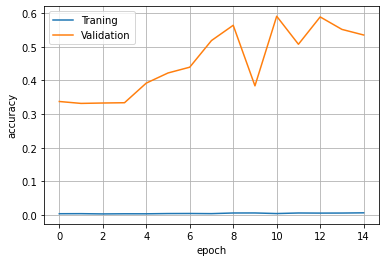

In [32]:
showResults(results, accuracy = True)

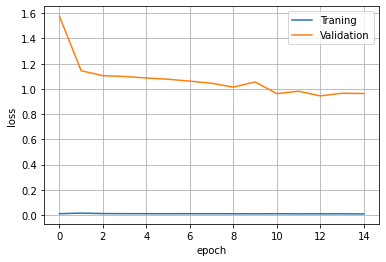

In [33]:
showResults(results, accuracy = False)

We have seen some pretty bad results, Now let's find what really causing our model to perform very bad

In [34]:
def plotRgb(loader):
    for img, label in loader:
        img = img.to(torch.device('cpu'))
        print(img.size())
        sns.set(rc={"figure.figsize":(18, 8)})
        sns.distplot(img[-1, 0,:, :])
        sns.distplot(img[-1, 1,:, :])
        sns.distplot(img[-1, 2,:, :])
        break

torch.Size([128, 3, 80, 80])


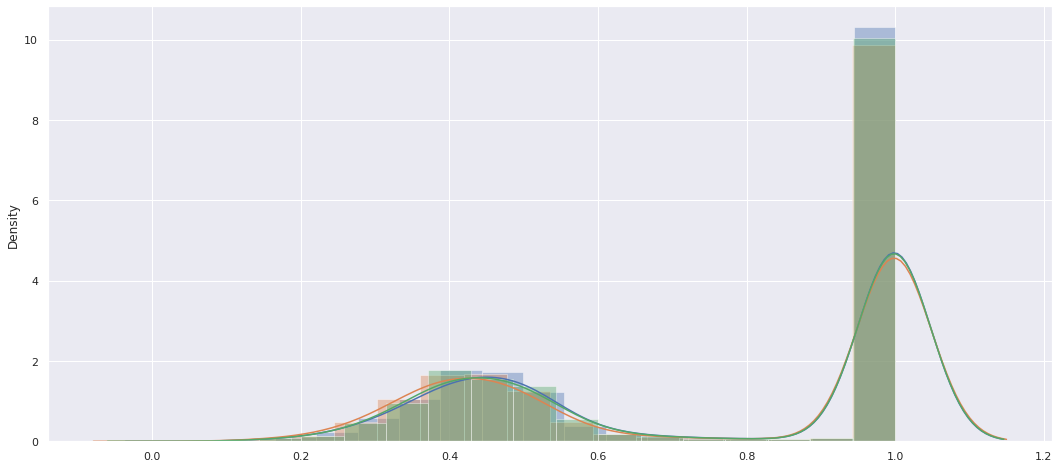

In [35]:
plotRgb(trainLoader)

You can see our color channels are distributed randomly, The only solution we have right now is to normalize the color channels. Let's see our model's performance with normalization